In [90]:
import os
import torch
import numpy as np
import cv2
import pandas as pd

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats as st

In [70]:
if torch.cuda.is_available():
    device=torch.device(type="cuda",index=0)
else:
    device=torch.device(type="cpu",index=0)

print(device)

cpu:0


In [71]:
train_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train'
test_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test'
val_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val'

# define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda img: torch.tensor(np.array(img)).float().permute(2, 0, 1))  # convert to tensor
])

# load datasets
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_data_dir, transform=transform)  
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)

# print class mappings
print("training class-to-index mapping:", train_dataset.class_to_idx)
print("validation class-to-index mapping:", val_dataset.class_to_idx)
print("testing class-to-index mapping:", test_dataset.class_to_idx)

# create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# test data loaders
for images, labels in train_loader:
    print("training image batch shape:", images.shape)  
    print("training label batch shape:", labels.shape)  
    break

for images, labels in val_loader:
    print("validation image batch shape:", images.shape)  
    print("validation label batch shape:", labels.shape)  
    break

for images, labels in test_loader:
    print("test image batch shape:", images.shape)  
    print("test label batch shape:", labels.shape)  
    break


Training Class-to-Index Mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Validation Class-to-Index Mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Testing Class-to-Index Mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Training Image batch shape: torch.Size([64, 3, 256, 256])
Training Label batch shape: torch.Size([64])
Validation Image batch shape: torch.Size([16, 3, 256, 256])
Validation Label batch shape: torch.Size([16])
Test Image batch shape: torch.Size([64, 3, 256, 256])
Test Label batch shape: torch.Size([64])


Image batch shape: torch.Size([64, 3, 256, 256])
Label batch shape: torch.Size([64])


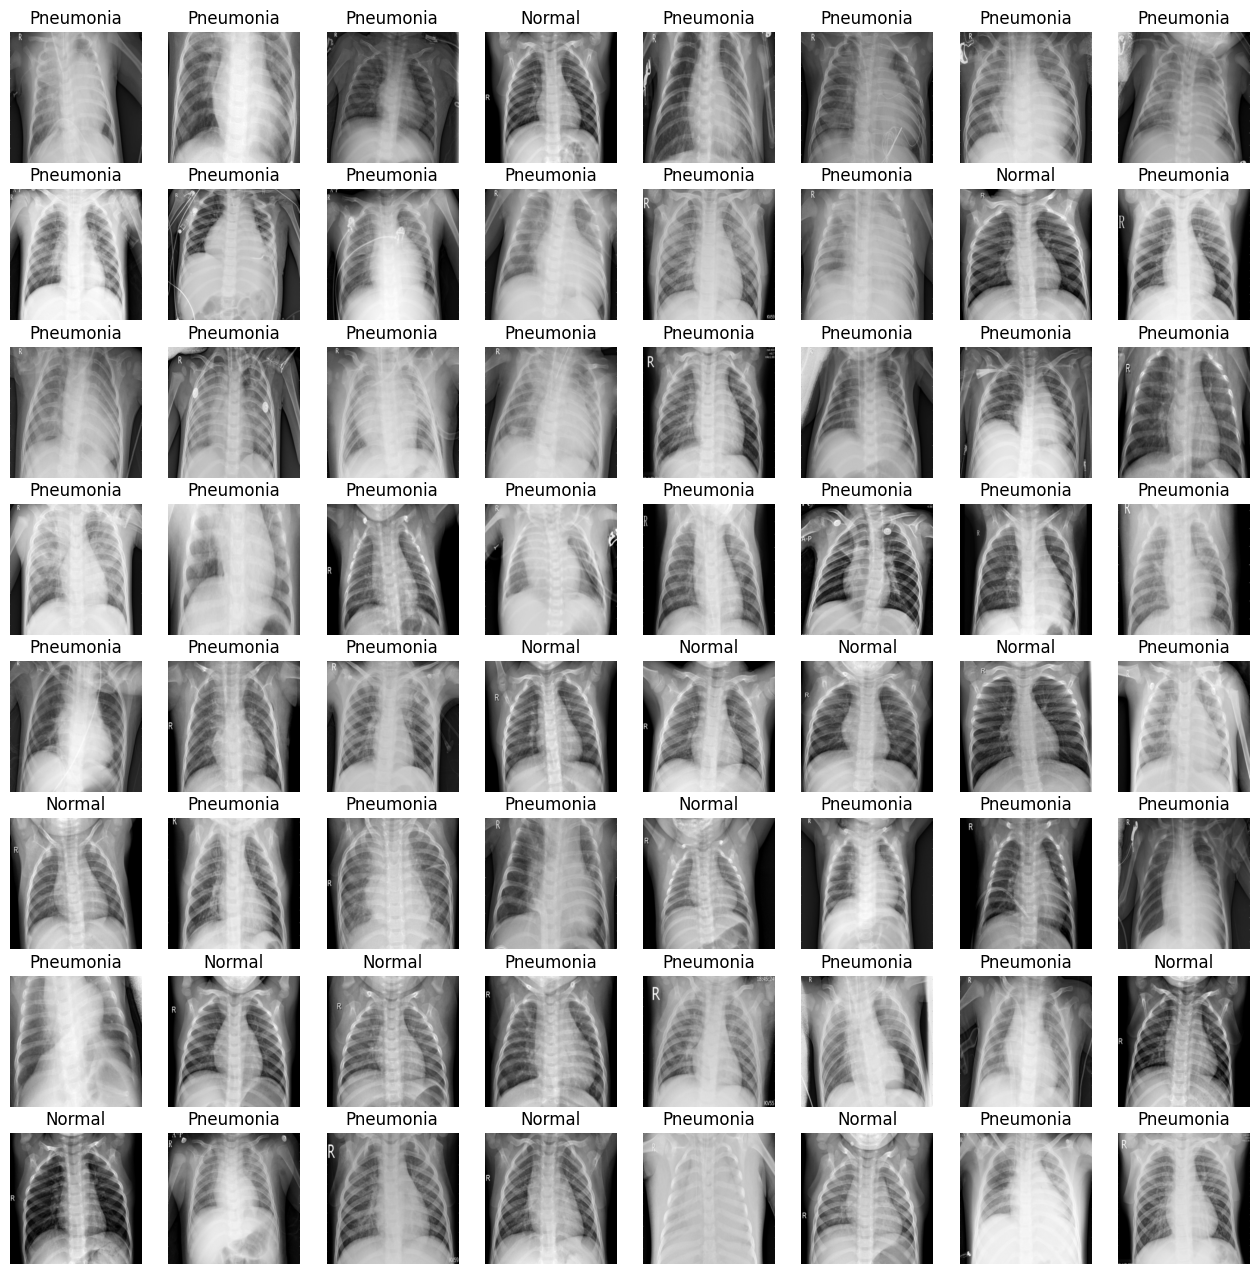

In [72]:
# test the data loader and display one batch of images
for images, labels in train_loader:
    print("Image batch shape:", images.shape)  # should print [batch_size, channels, 256, 256]
    print("Label batch shape:", labels.shape)  # should print [batch_size]
    
    n_images = images.shape[0]
    ncols = 8
    nrows = (n_images + ncols - 1) // ncols  # calculate number of rows needed
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
    
    # flatten the axes array for easy iteration
    axes = axes.flatten()
    
    for i in range(n_images):
        # convert tensor to numpy and move channels to the last axis (for displaying)
        img = images[i].numpy().transpose((1, 2, 0))
        
        # normalize to [0, 1] for proper display
        img = (img - img.min()) / (img.max() - img.min())
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # set label as "pneumonia" or "normal"
        label = "Pneumonia" if labels[i].item() == 1 else "Normal"
        axes[i].set_title(f"{label}")
    
    # hide any extra axes
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
    
    # save the image to a file
    plt.savefig('batch_images.png', dpi=300)  # save the figure as a png file
    
    plt.show()
    break  # display only one batch


In [73]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.relu = nn.ReLU()

        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(8)
        self.mp1 = nn.MaxPool2d(kernel_size=(4, 4), stride=4, padding=0)

        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        self.mp2 = nn.MaxPool2d(kernel_size=(4, 4), stride=4, padding=0)

        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(32)
        self.mp3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)

        # fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(64)
        self.mp4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)

        # flatten layer
        self.flatten = nn.Flatten()

        # fully connected layers
        self.lin1 = nn.Linear(in_features=64 * 2 * 2, out_features=128)  # adjusted input size
        self.bn5 = nn.BatchNorm1d(128)

        self.lin2 = nn.Linear(in_features=128, out_features=64)
        self.bn6 = nn.BatchNorm1d(64)

        self.lin3 = nn.Linear(in_features=64, out_features=2)

    def forward(self, x):
        # apply first convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.mp1(x)

        # apply second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.mp2(x)

        # apply third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.mp3(x)

        # apply fourth convolutional block
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.mp4(x)

        # flatten and pass through fully connected layers
        x = self.flatten(x)
        
        x = self.lin1(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.bn6(x)
        x = self.relu(x)
        x = self.lin3(x)

        # apply softmax for class probabilities
        output = torch.softmax(x, dim=1)
        return output


In [74]:
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    num_correct = 0
    total_samples = 0
    
    pbar = tqdm(dataloader, desc="Training")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        pred = model(imgs)
        loss = loss_fn(pred, labels)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        num_correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
        total_samples += labels.size(0)
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = (num_correct / total_samples) * 100
    return avg_loss, accuracy

In [76]:
def test_one_epoch(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    num_correct = 0
    total_samples = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Testing")
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            pred = model(imgs)
            loss = loss_fn(pred, labels)
            total_loss += loss.item()
            num_correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
            total_samples += labels.size(0)
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    avg_loss = total_loss / len(dataloader)
    accuracy = (num_correct / total_samples) * 100
    return avg_loss, accuracy

In [77]:
def val_one_epoch(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    num_correct = 0
    total_samples = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validating")
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            pred = model(imgs)
            loss = loss_fn(pred, labels)
            total_loss += loss.item()
            num_correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
            total_samples += labels.size(0)
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    avg_loss = total_loss / len(dataloader)
    accuracy = (num_correct / total_samples) * 100
    return avg_loss, accuracy

In [88]:
# 10 epochs were already trained, following are the next 10 epochs, in total there are 20 epochs
# the results are after 20 epochs

n_epochs = 10


for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")

    train_loss, train_acc = train_one_epoch(train_loader, model, loss_fn, optimizer)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    test_loss, test_acc = test_one_epoch(test_loader, model, loss_fn)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    val_loss, val_acc = val_one_epoch(val_loader, model, loss_fn)
    print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.2f}%")

    print("-----------------------------------------------------")

Epoch 1/10


Training: 100%|██████████| 82/82 [02:41<00:00,  1.97s/it, loss=0.3162]


Train Loss: 0.3220, Train Accuracy: 99.19%


Testing: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=0.5935]


Test Loss: 0.5838, Test Accuracy: 72.12%


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s, loss=0.6060]


Test Loss: 0.6060, Test Accuracy: 68.75%
-----------------------------------------------------
Epoch 2/10


Training: 100%|██████████| 82/82 [02:37<00:00,  1.93s/it, loss=0.3137]


Train Loss: 0.3194, Train Accuracy: 99.44%


Testing: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=0.5218]


Test Loss: 0.5222, Test Accuracy: 78.85%


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=0.5266]


Test Loss: 0.5266, Test Accuracy: 75.00%
-----------------------------------------------------
Epoch 3/10


Training: 100%|██████████| 82/82 [02:37<00:00,  1.92s/it, loss=0.3134]


Train Loss: 0.3195, Train Accuracy: 99.44%


Testing: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it, loss=0.5285]


Test Loss: 0.5240, Test Accuracy: 78.53%


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s, loss=0.6308]


Test Loss: 0.6308, Test Accuracy: 68.75%
-----------------------------------------------------
Epoch 4/10


Training: 100%|██████████| 82/82 [02:37<00:00,  1.92s/it, loss=0.3151]


Train Loss: 0.3205, Train Accuracy: 99.31%


Testing: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it, loss=0.5611]


Test Loss: 0.5825, Test Accuracy: 72.28%


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s, loss=0.7112]


Test Loss: 0.7112, Test Accuracy: 56.25%
-----------------------------------------------------
Epoch 5/10


Training: 100%|██████████| 82/82 [02:38<00:00,  1.93s/it, loss=0.3140]


Train Loss: 0.3215, Train Accuracy: 99.18%


Testing: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=0.5466]


Test Loss: 0.5059, Test Accuracy: 80.45%


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s, loss=0.4735]


Test Loss: 0.4735, Test Accuracy: 81.25%
-----------------------------------------------------
Epoch 6/10


Training: 100%|██████████| 82/82 [02:38<00:00,  1.93s/it, loss=0.3150]


Train Loss: 0.3227, Train Accuracy: 99.14%


Testing: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it, loss=0.6604]


Test Loss: 0.5623, Test Accuracy: 74.36%


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s, loss=0.4749]


Test Loss: 0.4749, Test Accuracy: 81.25%
-----------------------------------------------------
Epoch 7/10


Training: 100%|██████████| 82/82 [02:38<00:00,  1.93s/it, loss=0.3135]


Train Loss: 0.3186, Train Accuracy: 99.42%


Testing: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it, loss=0.5990]


Test Loss: 0.5589, Test Accuracy: 74.84%


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s, loss=0.5272]


Test Loss: 0.5272, Test Accuracy: 81.25%
-----------------------------------------------------
Epoch 8/10


Training: 100%|██████████| 82/82 [02:38<00:00,  1.93s/it, loss=0.3134]


Train Loss: 0.3179, Train Accuracy: 99.54%


Testing: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it, loss=0.5758]


Test Loss: 0.5867, Test Accuracy: 71.79%


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s, loss=0.6239]


Test Loss: 0.6239, Test Accuracy: 68.75%
-----------------------------------------------------
Epoch 9/10


Training: 100%|██████████| 82/82 [02:37<00:00,  1.92s/it, loss=0.3429]


Train Loss: 0.3186, Train Accuracy: 99.52%


Testing: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it, loss=0.4705]


Test Loss: 0.5567, Test Accuracy: 75.00%


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s, loss=0.6060]


Test Loss: 0.6060, Test Accuracy: 75.00%
-----------------------------------------------------
Epoch 10/10


Training: 100%|██████████| 82/82 [02:38<00:00,  1.93s/it, loss=0.3256]


Train Loss: 0.3179, Train Accuracy: 99.54%


Testing: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it, loss=0.5496]


Test Loss: 0.5224, Test Accuracy: 78.53%


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s, loss=0.4374]

Test Loss: 0.4374, Test Accuracy: 93.75%
-----------------------------------------------------


Image batch shape: torch.Size([64, 3, 256, 256])
Label batch shape: torch.Size([64])


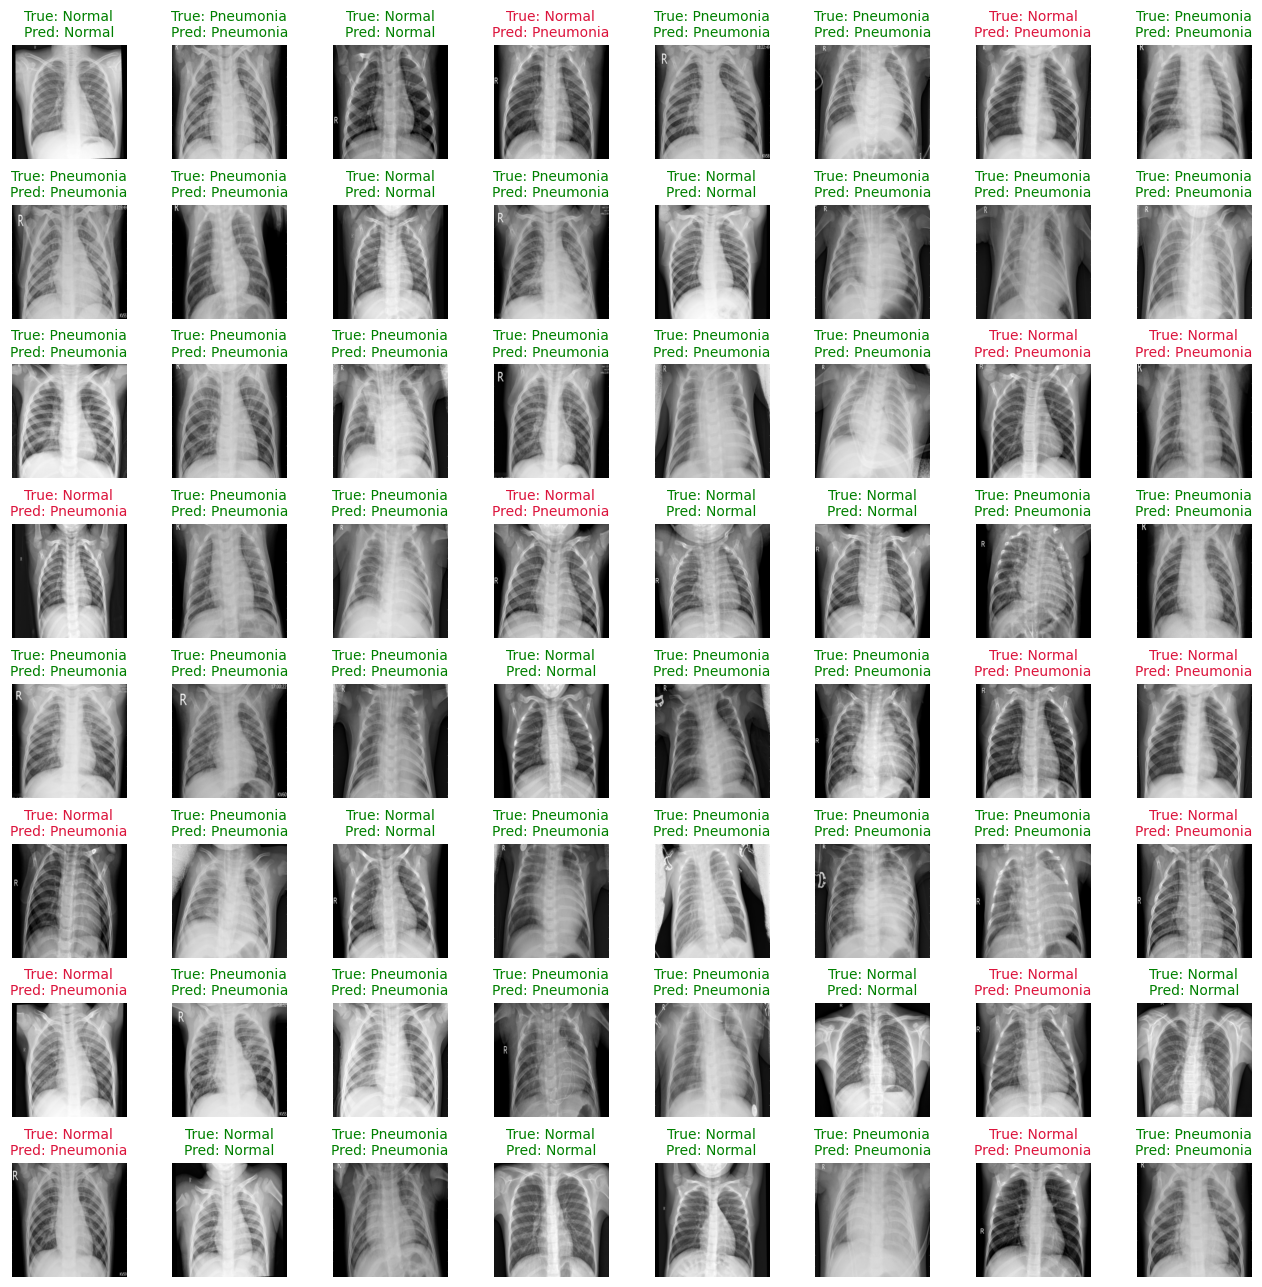

In [89]:
# set model to evaluation mode
model.eval()

# test the data loader and display one batch of images
for images, labels in test_loader:
    print("image batch shape:", images.shape)  # print image shape
    print("label batch shape:", labels.shape)  # print label shape
    
    # move images and labels to device
    images = images.to(device)
    labels = labels.to(device)
    
    # get predictions from the model
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)

    # move tensors back to cpu for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted_labels = predicted_labels.cpu()

    n_images = images.shape[0]
    ncols = 8
    nrows = (n_images + ncols - 1) // ncols  # calculate rows needed
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
    
    axes = axes.flatten()
    
    for i in range(n_images):
        img = images[i].numpy().transpose((1, 2, 0))  # convert tensor to numpy
        
        # normalize image for display
        img = (img - img.min()) / (img.max() - img.min())
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # get true and predicted labels
        true_label = "pneumonia" if labels[i].item() == 1 else "normal"
        predicted_label = "pneumonia" if predicted_labels[i].item() == 1 else "normal"

        # set title with labels
        color = "green" if true_label == predicted_label else "crimson"
        axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10, color=color)
    
    # hide extra axes
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
        
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    # save the image
    plt.savefig('batch_images_with_predictions.png', dpi=300)
    
    plt.show()
    break  # display only one batch
